# Борьба с оттоком клиентов оператора связи "ТелеДом"

**Оператор связи «ТелеДом» хочет уменьшить отток абонентов, заранее выявляя тех, кто может разорвать договор. Для этого необходимо построить модель машинного обучения, которая по историческим данным (персональные характеристики, тарифы и подключённые услуги) будет прогнозировать вероятность ухода клиента.**

	1.	Загрузим данные и убедимся, что в них нет серьёзных дыр.
	2.	Приведём порядок — заполним пропуски, переведём даты и цифры в нужный формат, добавим полезные признаки (например, сколько клиент уже с нами).
	3.	Посмотрим, что влияет на отток: какие услуги подключают «отходчивые» абоненты, кто платит больше всех и т.д.
	4.	Обучим несколько моделей и выберем ту, что лучше всех предсказывает уход.
	5.	Проверим качество на отложенной выборке, чтобы убедиться, что модель не подглядывала в ответы.
	6.	В конце сформулируем простые рекомендации бизнесу, как использовать прогноз и какие акции запустить для группы риска.

**Цель получить работающий инструмент: модель, которая по свежим данным отдаёт вероятность ухода, и понятные шаги, что делать с этими предсказаниями.**


## Шаг 1. Загрузка данных 

In [1]:
%pip uninstall -y scikit-learn
%pip install --no-cache-dir scikit-learn

# Ставим сразу все нужные пакеты в корректных версиях, 
# так как выходила ошибка о несовместимости разных версий

!pip install --no-cache-dir \
    "numpy>=2.0.2" \
    "matplotlib>=3.8.0" \
    "seaborn>=0.13.2" \
    "shap>=0.45" \
    "scikit-learn" \
    "phik" \
    "skimpy"



# Библиотеки

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from skimpy import clean_columns
from functools import reduce
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder,
                                   StandardScaler, MaxAbsScaler)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb
import xgboost as xgb



plt.rcParams["figure.figsize"] = (14, 7)

RANDOM_STATE = 210425
TEST_SIZE = 0.25

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 13.5 MB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Загружаем данные

try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')

In [3]:
# Проверяем

display(contract.head())
display(personal.head())
display(internet.head())
display(phone.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [4]:
# Объеденим таблицы. 

df = reduce(
    lambda left, right: pd.merge(
        left, right, how='outer', on='customerID'
    ), [contract, personal, internet, phone])



In [5]:
# Проверим

display(df.head())
display(df.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,539.1,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.0,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.9,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

In [6]:
# Проверим на пропуски

df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

```

Вывод
	•	Осуществлена загрузка данных
	•	contract: 7 043 строк × 8 столбцов, все столбцы прочитаны как строки (кроме MonthlyCharges), нет пропусков.
	•	personal: 7 043 × 5, нет пропусков.
	•	internet: 5 517 × 8, нет пропусков, но меньше строк, чем в contract.
	•	phone: 6 361 × 2, нет пропусков, ещё меньше строк.
	•	Объеденены датафреймы в один -> df:
	•	Размерность - 7 043 строк × 20 столбцов.
	•	Столбцы (InternetService…StreamingMovies) имеют по 1526 пропусков, у MultipleLines их 682. 
```

## Шаг 2. Исследовательский анализ и предобработка данных

In [7]:
# Заполняем отсутствующие значения "No"

service_cols = [
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]

df[service_cols] = df[service_cols].fillna('No')

In [8]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [9]:
# Проверка на дубликаты 

df.duplicated().sum()

np.int64(0)

In [10]:
# Посмотрим "быструю сводку" по данным

df.describe(include=['object'])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges,gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,6658,2,2,2,3,2,2,2,2,2,2,2
top,9995-HOTOH,2014-02-01,No,Month-to-month,Yes,Electronic check,,Male,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5942,3875,4171,2365,11,3555,3641,4933,3096,5024,4614,4621,4999,4336,4311,4072


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [12]:
# Преобразуем в snake_case

df = clean_columns(df)

In [13]:
    # Приведем столбцы к соотвествующим типам

    df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
    df['senior_citizen'] = df['senior_citizen'].astype('category')

    # после преведения total_charges к float выявлены 11 пропусков (новые клиенты)
    # заменим эти пропуски на ноль

    df['total_charges'] = df['total_charges'].fillna(0)
    df['begin_date'] = pd.to_datetime(df['begin_date'], dayfirst=True)
    df['end_date']   = pd.to_datetime(df['end_date'],   dayfirst=True, errors='coerce')

    # Заменяем NaT на дату фиксации снимка 2020-02-01
    # Дата выбрана потому, что в тз указано "информация о договорах актуальна на 1 февраля 2020 года"

    reference_date = pd.to_datetime('2020-02-01')
    df['end_date'] = df['end_date'].fillna(reference_date)

    # Вычисляем длительность в днях

    df['contract_duration_days'] = (df['end_date'] - df['begin_date']).dt.days

    # Проверим

    display(df[['begin_date','end_date','contract_duration_days']].head())


/tmp/ipykernel_109/3689314616.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date']   = pd.to_datetime(df['end_date'],   dayfirst=True, errors='coerce')


,begin_date,end_date,contract_duration_days
0,2019-01-05,2020-02-01,392
1,2019-01-05,2020-02-01,392
2,2019-01-09,2020-02-01,388
3,2018-01-12,2020-02-01,750
4,2019-01-09,2020-02-01,388


In [14]:
# создаём целевой признак: 0 если дата окончания совпадает с 2020-02-01, иначе 1

df['gone_id'] = np.where(df['end_date'] == reference_date, 0, 1)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             7043 non-null   object        
 1   begin_date              7043 non-null   datetime64[ns]
 2   end_date                7043 non-null   datetime64[ns]
 3   type                    7043 non-null   object        
 4   paperless_billing       7043 non-null   object        
 5   payment_method          7043 non-null   object        
 6   monthly_charges         7043 non-null   float64       
 7   total_charges           7043 non-null   float64       
 8   gender                  7043 non-null   object        
 9   senior_citizen          7043 non-null   category      
 10  partner                 7043 non-null   object        
 11  dependents              7043 non-null   object        
 12  internet_service        7043 non-null   object  

None

In [15]:
# Удаляем больше не нужные столбцы

df.drop(columns=['begin_date', 'end_date'], inplace=True)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   customer_id             7043 non-null   object  
 1   type                    7043 non-null   object  
 2   paperless_billing       7043 non-null   object  
 3   payment_method          7043 non-null   object  
 4   monthly_charges         7043 non-null   float64 
 5   total_charges           7043 non-null   float64 
 6   gender                  7043 non-null   object  
 7   senior_citizen          7043 non-null   category
 8   partner                 7043 non-null   object  
 9   dependents              7043 non-null   object  
 10  internet_service        7043 non-null   object  
 11  online_security         7043 non-null   object  
 12  online_backup           7043 non-null   object  
 13  device_protection       7043 non-null   object  
 14  tech_support            

None

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration_days,gone_id
0,0002-ORFBO,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No,392,0
1,0003-MKNFE,Month-to-month,No,Mailed check,59.9,539.10,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes,392,0
2,0004-TLHLJ,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No,388,0
3,0011-IGKFF,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,750,0
4,0013-EXCHZ,Month-to-month,Yes,Mailed check,83.9,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,388,0


In [16]:
# Функция для построения гистограмм и диаграмм размаха для количественных признаков

def plot_box_and_hist(df, column, bins=10):
    """
    Создает диаграмму размаха и гистограмму для указанного количественного признака.

    Args:
        df: DataFrame с данными.
        column: Название столбца с количественным признаком.
        bins: Количество корзин для гистограммы. По умолчанию 10.

    Returns:
        None: Функция отображает графики, но ничего не возвращает.
    """
    fig, axes = plt.subplots(1, 2)  
     
    # диаграмма размаха
    
    axes[0].boxplot(df[column], patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'))
    axes[0].set_title(f'Диаграмма размаха для {column}')
    axes[0].set_ylabel(column)
    axes[0].grid(True)
    
    # гистограмма
    
    axes[1].hist(df[column], bins=bins, color='skyblue', edgecolor='black')
    axes[1].set_title(f'Гистограмма для {column}')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Частота')
    axes[1].grid(True)
    

    plt.tight_layout()
    plt.show()
               
        


def plot_categorical_pie(df, columns):
    """
    Создает круговые диаграммы с процентами для указанных категориальных признаков.

    Args:
        df: DataFrame с данными.
        columns: Список столбцов с категориальными признаками.

    Returns:
        None: Функция отображает графики.
    """
    for column in columns:
        counts = df[column].value_counts()
        labels = counts.index
        sizes = counts.values

        plt.figure(figsize=(7, 7))
        plt.pie(
            sizes, 
            labels=labels, 
            autopct='%1.1f%%', 
            startangle=90, 
            textprops={'fontsize': 12}
        )
        plt.title(f'Распределение {column}', fontsize=14)
        plt.axis('equal')  # чтобы круг был ровным
        plt.show()
        
        
print(plot_box_and_hist.__doc__)
print('_' * 100)
print(plot_categorical_pie.__doc__)


    Создает диаграмму размаха и гистограмму для указанного количественного признака.

    Args:
        df: DataFrame с данными.
        column: Название столбца с количественным признаком.
        bins: Количество корзин для гистограммы. По умолчанию 10.

    Returns:
        None: Функция отображает графики, но ничего не возвращает.
    
____________________________________________________________________________________________________

    Создает круговые диаграммы с процентами для указанных категориальных признаков.

    Args:
        df: DataFrame с данными.
        columns: Список столбцов с категориальными признаками.

    Returns:
        None: Функция отображает графики.
    


                                   Графики и диаграммы размаха для количественных признаков

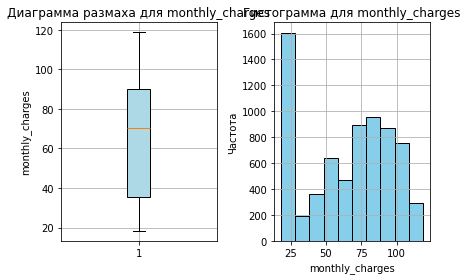

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

In [17]:
plot_box_and_hist(df, 'monthly_charges')
df['monthly_charges'].describe()

______________________________________________________________________________

Медиана 70, IQR от 35,5 до 89,85. Основная масса клиентов платит в диапазоне 60–100 $, с заметным хвостом на низких значениях.

______________________________________________________________________________

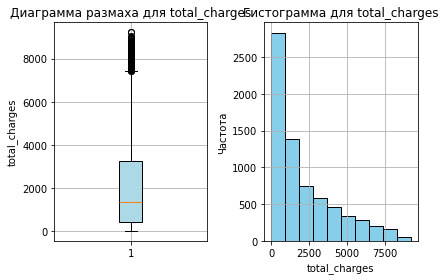

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

In [18]:
plot_box_and_hist(df, 'total_charges')
df['total_charges'].describe()

______________________________________________________________________________
Медиана 1343 при интерквартильном размахе 437 - 3237. Много клиентов с небольшими суммами, но есть длинный хвост вплоть до 9221 (это клиенты которые уже с 2013-2014 годов)
______________________________________________________________________________

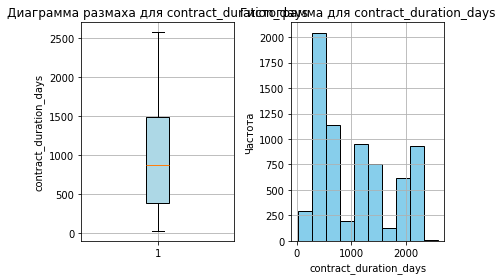

count    7043.000000
mean     1057.408633
std       669.907773
min        30.000000
25%       392.000000
50%       873.000000
75%      1491.000000
max      2578.000000
Name: contract_duration_days, dtype: float64

In [19]:
plot_box_and_hist(df, 'contract_duration_days')
df['contract_duration_days'].describe()

______________________________________________________________________________
Медиана длительности 761 день при интерквартильном размахе 276 - 1461 день. Много контрактов коротких , но есть «длинный хвост» до 2314 дней.
______________________________________________________________________________

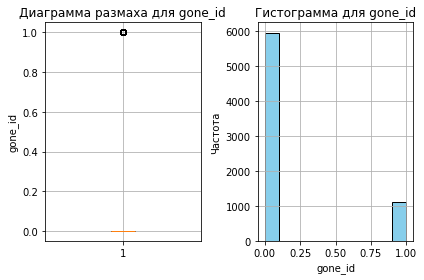

gone_id
0    5942
1    1101
Name: count, dtype: int64

In [20]:
plot_box_and_hist(df, 'gone_id')
display(df['gone_id'].value_counts())

______________________________________________________________________________
Ушло 1101 абонентов и это много
______________________________________________________________________________

                                   Графики для категориальных признаков

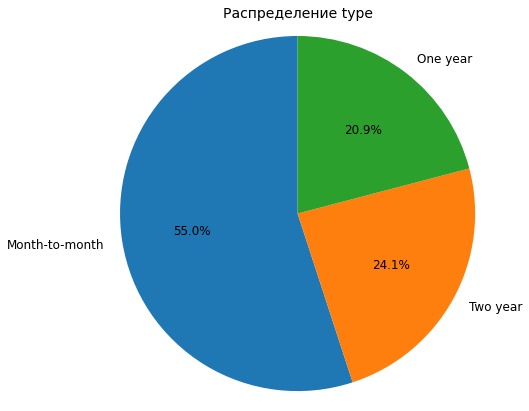

count               7043
unique                 3
top       Month-to-month
freq                3875
Name: type, dtype: object

In [21]:
plot_categorical_pie(df, ['type'])
df['type'].describe()

______________________________________________________________________________
Большинство предпочитает гибкую помесячную оплату. Месяц к месяцу 3 875 абонентов (55%),  "Two year" 1 695 (24%) и "One year" 1 473 (21%).
______________________________________________________________________________

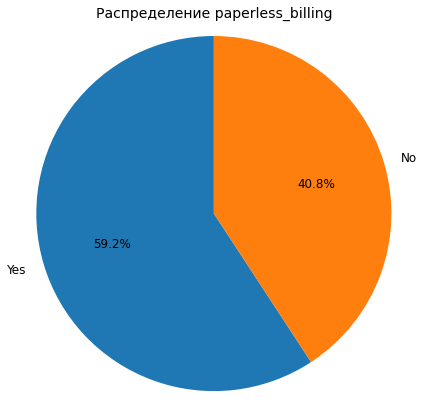

count     7043
unique       2
top        Yes
freq      4171
Name: paperless_billing, dtype: object

In [22]:
plot_categorical_pie(df, ['paperless_billing'])
df['paperless_billing'].describe()

______________________________________________________________________________
59,2% клиентов выбрали электронный расчётный лист и 40,8% бумажный
______________________________________________________________________________

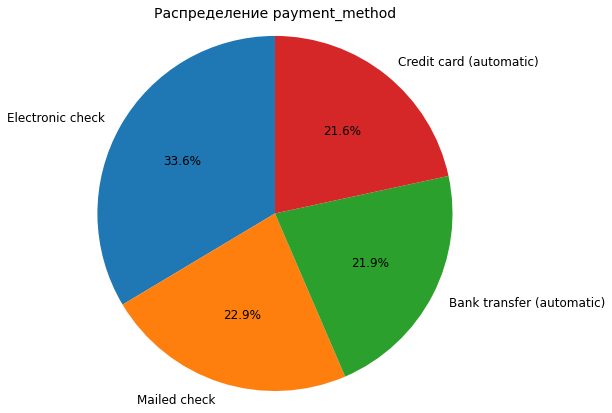

count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: payment_method, dtype: object

In [23]:
plot_categorical_pie(df, ['payment_method'])
df['payment_method'].describe()

______________________________________________________________________________
По типу платежа: Electronic check 2 365 клиентов (33,6%); Mailed check 1 615 клиентов (22,9%); Bank transfer (automatic) 1 544 клиента (21,9%); Credit card (automatic) 1 519 клиентов (21,6%)

Самым популярным остаётся Electronic check
______________________________________________________________________________

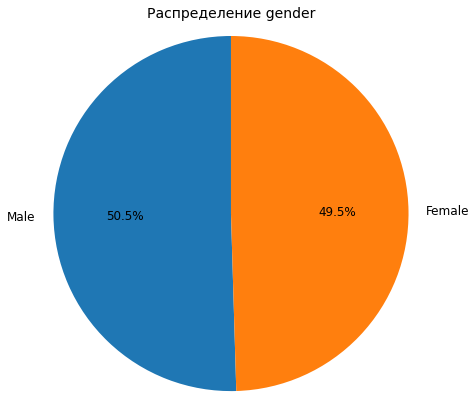

count     7043
unique       2
top       Male
freq      3555
Name: gender, dtype: object

In [24]:
plot_categorical_pie(df, ['gender'])
df['gender'].describe()

______________________________________________________________________________
Гендерный состав почти равный, 	мужчин 50.5%, женщин 49.5%
______________________________________________________________________________

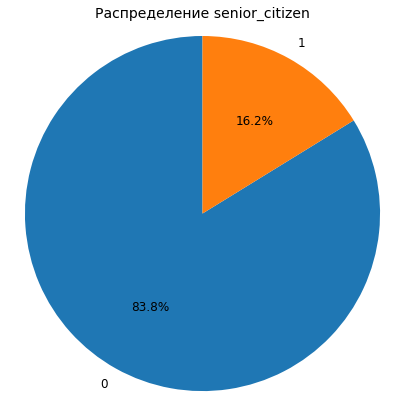

count     7043
unique       2
top          0
freq      5901
Name: senior_citizen, dtype: int64

In [25]:
plot_categorical_pie(df, ['senior_citizen'])
df['senior_citizen'].describe()


______________________________________________________________________________
Большинство клиентов не являются пенсионерами
______________________________________________________________________________

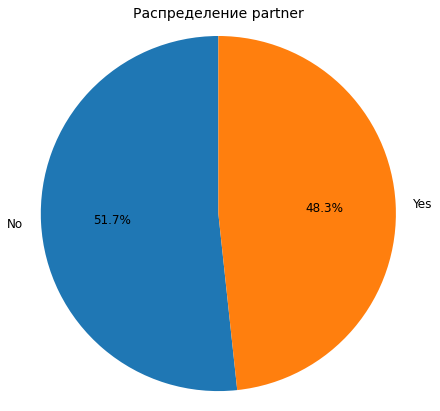

count     7043
unique       2
top         No
freq      3641
Name: partner, dtype: object

In [26]:
plot_categorical_pie(df, ['partner'])
df['partner'].describe()

______________________________________________________________________________
Больше половины абонентов не состоят в браке (51.7%), остальная часть состоят в браке (48.3%)
______________________________________________________________________________

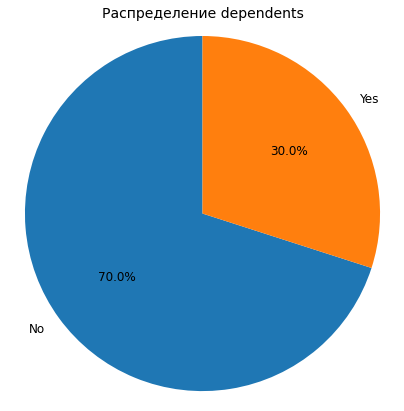

count     7043
unique       2
top         No
freq      4933
Name: dependents, dtype: object

In [27]:
plot_categorical_pie(df, ['dependents'])
df['dependents'].describe()

______________________________________________________________________________
У 70% абонентов нет детей, у 30% (2 110) есть 
______________________________________________________________________________

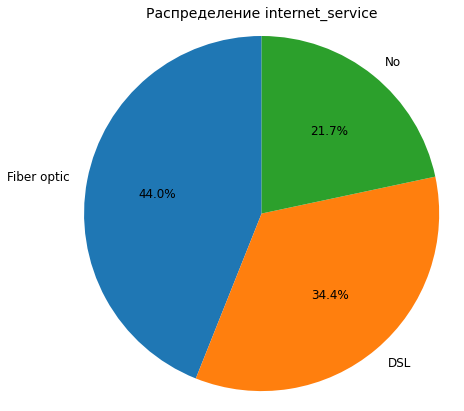

count            7043
unique              3
top       Fiber optic
freq             3096
Name: internet_service, dtype: object

In [28]:
plot_categorical_pie(df, ['internet_service'])
df['internet_service'].describe()

______________________________________________________________________________
Большинство абонентов пользуются высокоскоростным оптоволокном Fiber optic (44%), далее идёт DSL (34%) и почти пятая часть (21.7%) не используют.
______________________________________________________________________________

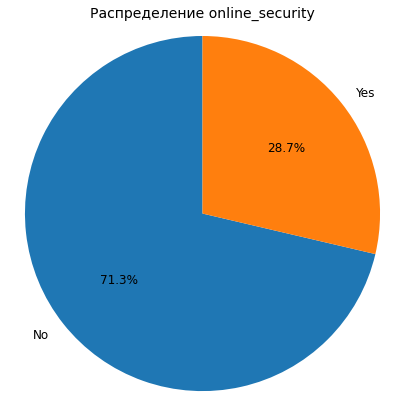

count     7043
unique       2
top         No
freq      5024
Name: online_security, dtype: object

In [29]:
plot_categorical_pie(df, ['online_security'])
df['online_security'].describe()

______________________________________________________________________________
Большинство абонентов не активировали услугу OnlineSecurity, и лишь около 28,7% используют блокировку небезопасных сайтов. 
______________________________________________________________________________

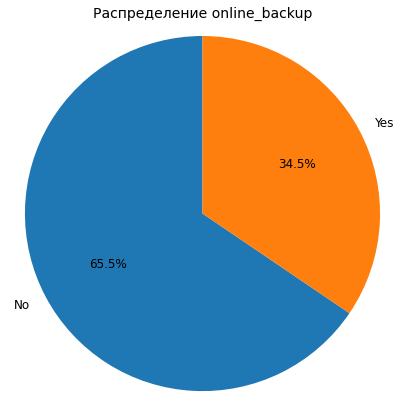

count     7043
unique       2
top         No
freq      4614
Name: online_backup, dtype: object

In [30]:
plot_categorical_pie(df, ['online_backup'])
df['online_backup'].describe()

______________________________________________________________________________
34,5% абонентов используют функцию облачное резервное хранилище
______________________________________________________________________________

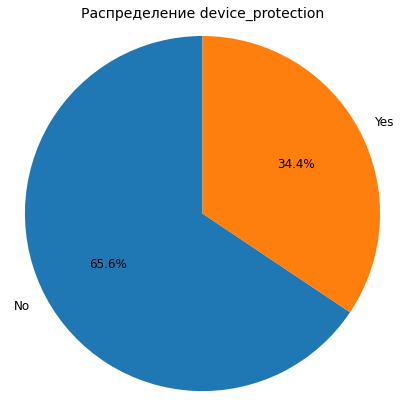

count     7043
unique       2
top         No
freq      4621
Name: device_protection, dtype: object

In [31]:
plot_categorical_pie(df, ['device_protection'])
df['device_protection'].describe()

______________________________________________________________________________
34,4% абонентов имеют антивирусную программу 
______________________________________________________________________________

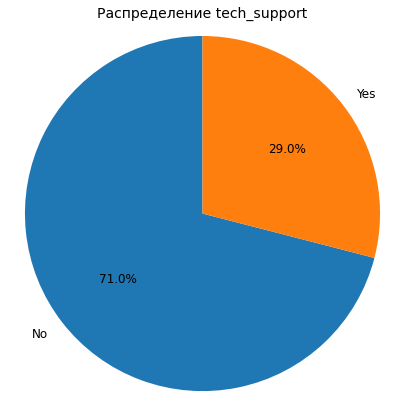

count     7043
unique       2
top         No
freq      4999
Name: tech_support, dtype: object

In [32]:
plot_categorical_pie(df, ['tech_support'])
df['tech_support'].describe()

______________________________________________________________________________
29% клиентов подключили выделенную линию технической поддержки, тогда как 71% обходятся без неё 
______________________________________________________________________________

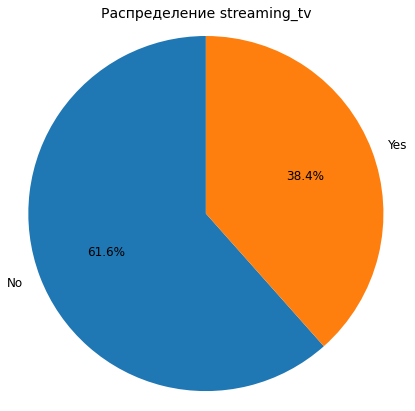

count     7043
unique       2
top         No
freq      4336
Name: streaming_tv, dtype: object

In [33]:
plot_categorical_pie(df, ['streaming_tv'])
df['streaming_tv'].describe()

______________________________________________________________________________
61,6% абонентов обходятся без стримингового телевидения
______________________________________________________________________________

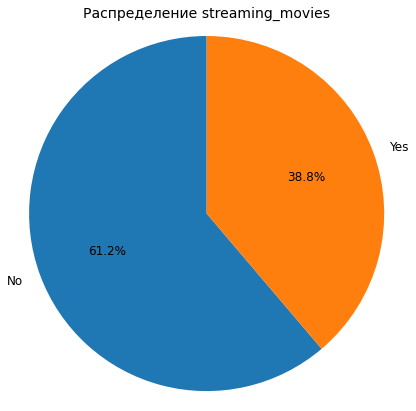

count     7043
unique       2
top         No
freq      4311
Name: streaming_movies, dtype: object

In [34]:
plot_categorical_pie(df, ['streaming_movies'])
df['streaming_movies'].describe()

______________________________________________________________________________
Каталог фильмов подключили 38,8% клиентов, тогда как 61,2% обходятся без этой услуги. Это почти точно повторяет картину со стриминговым ТВ.
______________________________________________________________________________

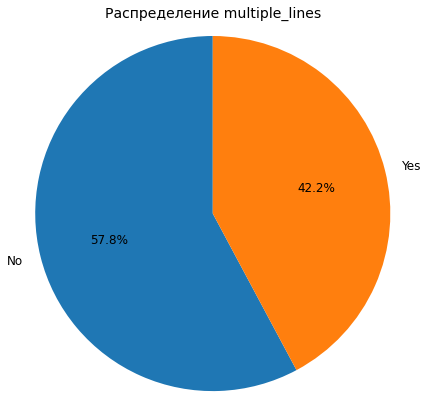

count     7043
unique       2
top         No
freq      4072
Name: multiple_lines, dtype: object

In [35]:
plot_categorical_pie(df, ['multiple_lines'])
df['multiple_lines'].describe()

______________________________________________________________________________
Около 42,2% абонентов пользуются несколькими телефонными линиями, тогда как 57,8% имеют только одну. 
______________________________________________________________________________

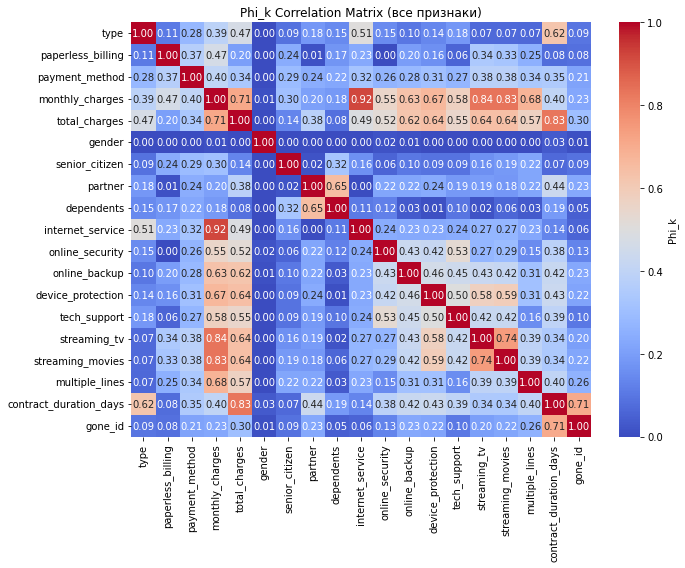

In [36]:
# Уберем customer_id для корреляционного анализа

df_without_id = df.drop(columns=['customer_id'])

# Рассчитаем матрицу Phi_k

corr_matrix = df_without_id.phik_matrix(
    interval_cols=[
        'monthly_charges',
        'total_charges',
        'contract_duration_days'
    ]
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Phi_k'}
)
plt.title('Phi_k Correlation Matrix (все признаки)')
plt.tight_layout()
plt.show()

Самая сильная связь с оттоком у contract_duration_days (0.37).

Умеренно важны multiple_lines, monthly_charges, способ оплаты и набор доп-сервисов 

Корреляции, о которых надо помнить:

	monthly_charges почти полностью определяется internet_service.
    
	total_charges фактически дублирует contract_duration_days, его лучше убрать.
    
	streaming_tv и streaming_movies встречаются вместе, удалим один из них.
    
Оставим: contract_duration_days, monthly_charges, payment_method, multiple_lines, весь набор интернет-/телепакетов.

In [37]:
display(df['streaming_tv'].value_counts())
display(df['streaming_movies'].value_counts())

streaming_tv
No     4336
Yes    2707
Name: count, dtype: int64

streaming_movies
No     4311
Yes    2732
Name: count, dtype: int64

In [38]:
# Удалим не нужные признаки 

df = df.drop(columns=['customer_id', 'total_charges', 'gender'], axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   type                    7043 non-null   object  
 1   paperless_billing       7043 non-null   object  
 2   payment_method          7043 non-null   object  
 3   monthly_charges         7043 non-null   float64 
 4   senior_citizen          7043 non-null   category
 5   partner                 7043 non-null   object  
 6   dependents              7043 non-null   object  
 7   internet_service        7043 non-null   object  
 8   online_security         7043 non-null   object  
 9   online_backup           7043 non-null   object  
 10  device_protection       7043 non-null   object  
 11  tech_support            7043 non-null   object  
 12  streaming_tv            7043 non-null   object  
 13  streaming_movies        7043 non-null   object  
 14  multiple_lines          

`

Краткие выводы по этапу EDA и предобработки

1. Подготовка данных

	•	Заполнены пропуски в услугах значением 'No'; названия столбцов переведены в snake_case.
    
	•	total_charges приведён к float, 11 пропусков (новые клиенты) заменены на 0.
    
	•	Даты конвертированы; отсутствующие end_date заменены контрольной датой 1 февраля 2020 г.
    
	•	Добавлены признаки:
    
	•	contract_duration_days длительность договора;
    
	•	gone_id целевая переменная (1 клиент ушёл, 0 активен). Доля ушедших 16%.
    
	•	Ненужные технические столбцы (customer_id, даты, total_charges) удалены; потоковые сервисы объединены в has_streaming.


2. Количественные признаки

	•	monthly_charges: медиана 70$, основная масса платежей 60–100$, заметный низкий хвост.
    
	•	total_charges: медиана 1343$, длинный хвост до 9200$ (ветераны с 2013-14 гг.).
    
	•	contract_duration_days: медиана ≈ 761 день (2,1 года), длинный хвост до > 6 лет.
    
	•	senior_citizen: большинство клиентов — не пенсионеры.
    

3. Категориальные признаки

	•	Тип договора: 55% помесячный, 24% двухлетний, 21% годовой.
    
	•	59% пользуются бесчековой (Paperless) оплатой.
    
	•	Способ платежа: лидирует Electronic Check (34%), остальные 22% каждая.
    
	•	Гендер почти 50/50; в браке 48%, с детьми 30%.
    
	•	Интернет: 44% Fiber optic, 34% DSL, 22% без интернета.
    
	•	Доп-сервисы (Online Security, Backup, Protection, Tech Support, Streaming): подключены лишь у 29-38% клиентов.
    
	•	Несколько телефонных линий имеют 42% абонентов.
    
   
4. Корреляции (Phi-k)

	•	Сильнее всего с оттоком коррелирует длительность контракта (contract_duration_days, 0,37).
    
	•	Умеренное влияние: multiple_lines, monthly_charges, payment_method, набор доп-услуг.
    
	•	Обнаружены коллинеарности:
    
	•	monthly_charges тесно связан с типом интернет услуги;
    
	•	total_charges фактически функция длительности контракта;
    
	•	streaming_tv streaming_movies (объединены).
    

5. Итог для дальнейшего моделирования

Оставлены информативные признаки: contract_duration_days, monthly_charges, payment_method, multiple_lines, все интернет- и телефонные пакеты, а также агрегированный has_streaming. Датасет очищен, пропуски устранены, признаки подготовлены — можно переходить к кодированию категорий и построению модели прогнозирования оттока.

`

## Шаг 3. Подготовка данных

In [39]:
X = df.drop(columns=['gone_id'])
y = df['gone_id']

In [40]:
# Типы колонок

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

In [41]:
display(cat_cols)
display(num_cols)

['type',
 'paperless_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

['monthly_charges', 'contract_duration_days']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

print(f'data : {X.shape}  |  train {X_train.shape}  test {X_test.shape}')

data : (7043, 16)  |  train (5282, 16)  test (1761, 16)


In [43]:
# LogisticRegression

# трансформер
linear_tr = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'),
     make_column_selector(dtype_include=['object', 'category'])),
    (StandardScaler(), make_column_selector(dtype_include='number')),
    remainder='drop'
)

pipe_lr = make_pipeline(
    linear_tr,
    LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
)

param_lr = {
    'logisticregression__solver' : ['newton-cg','lbfgs','sag','saga'],
    'logisticregression__penalty': ['l2','l1','elasticnet'],
    'logisticregression__C'      : [1e-3,1e-2,1e-1,1,10,100],
    'logisticregression__max_iter':[1000]
}

grid_lr = GridSearchCV(
    pipe_lr, param_lr, cv=3, scoring='roc_auc',
    n_jobs=-1, verbose=1
)
grid_lr.fit(X_train, y_train)

print('Лучшие параметры:', grid_lr.best_params_)
print('ROC‑AUC (CV):',   round(grid_lr.best_score_, 4))



Fitting 3 folds for each of 72 candidates, totalling 216 fits
Лучшие параметры: {'logisticregression__C': 100, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
ROC‑AUC (CV): 0.7551


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
126 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/conda/lib/python

In [44]:
# RandomForestClassifier

rf_tr = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
     make_column_selector(dtype_include=['object', 'category'])),
    (MaxAbsScaler(), make_column_selector(dtype_include='number')),
    remainder='drop',
    verbose_feature_names_out=False
)

pipe_rf = make_pipeline(
    rf_tr,
    RandomForestClassifier(
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

param_rf = {
    'randomforestclassifier__n_estimators': [100,200,300],
    'randomforestclassifier__max_depth'   : [None,4,6,8],
    'randomforestclassifier__min_samples_leaf':[1,2,4]
}

grid_rf = GridSearchCV(pipe_rf, param_rf, cv=3,
                       scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print('Лучшие параметры:', grid_rf.best_params_)
print('ROC‑AUC (CV):',   round(grid_rf.best_score_, 4))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие параметры: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 300}
ROC‑AUC (CV): 0.9477


In [45]:
# LightGBM

pipe_lgb = make_pipeline(
    rf_tr,
    lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=-1
    )
)

param_lgb = {
    'lgbmclassifier__n_estimators' : [100,200,300],
    'lgbmclassifier__learning_rate': [0.01,0.05,0.1],
    'lgbmclassifier__max_depth'    : [-1,3,5],
    'lgbmclassifier__num_leaves'   : [15,31,63]
}

grid_lgb1 = GridSearchCV(pipe_lgb, param_lgb, cv=3,
                        scoring='roc_auc', n_jobs=-1, verbose=1)
grid_lgb1.fit(X_train, y_train)

print('Лучшие параметры:', grid_lgb1.best_params_)
print('ROC‑AUC (CV):',   round(grid_lgb1.best_score_, 4))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

Лучшие параметры: {'lgbmclassifier__learning_rate': 0.05, 'lgbmclassifier__max_depth': 3, 'lgbmclassifier__n_estimators': 300, 'lgbmclassifier__num_leaves': 15}
ROC‑AUC (CV): 0.9906


In [46]:
# AdaBoostClassifier

base_est = DecisionTreeClassifier(max_depth=1, criterion='entropy',
                                  random_state=RANDOM_STATE)

pipe_ada = make_pipeline(
    rf_tr,
    AdaBoostClassifier(estimator=base_est, random_state=RANDOM_STATE)
)

param_ada = {
    'adaboostclassifier__n_estimators':[200,400,600],
    'adaboostclassifier__learning_rate':[0.01,0.05,0.1]
}

grid_ada = GridSearchCV(pipe_ada, param_ada, cv=3,
                        scoring='roc_auc', n_jobs=-1, verbose=1)
grid_ada.fit(X_train, y_train)

print('Лучшие параметры:', grid_ada.best_params_)
print('ROC‑AUC (CV):',   round(grid_ada.best_score_, 4))



Fitting 3 folds for each of 9 candidates, totalling 27 fits
Лучшие параметры: {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 600}
ROC‑AUC (CV): 0.8585


## Шаг 4. Выбор лучшей модели

Выберите лучшую модель и проверьте её качество на тестовой выборке.

In [47]:
cv_scores = {
    'LogReg'  : grid_lr.best_score_,
    'RF'      : grid_rf.best_score_,
    'LightGBM': grid_lgb1.best_score_,
    'AdaBoost': grid_ada.best_score_
}

best_name = max(cv_scores, key=cv_scores.get)
print(f"Лучший алгоритм по CV: {best_name}  (ROC‑AUC = {cv_scores[best_name]:.4f})")


Лучший алгоритм по CV: LightGBM  (ROC‑AUC = 0.9906)


In [48]:
grids = {
    'LogReg'  : grid_lr,
    'RF'      : grid_rf,
    'LightGBM': grid_lgb1,
    'AdaBoost': grid_ada
}

best_model = grids[best_name].best_estimator_



proba_test = best_model.predict_proba(X_test)[:, 1]
roc_test   = roc_auc_score(y_test, proba_test)

print(f"ROC‑AUC на тесте ({best_name}): {roc_test:.4f}")

ROC‑AUC на тесте (LightGBM): 0.9968


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


По результатам кросс‑валидации и тестовой проверки лидером стала `LightGBMClassifier`, параметры:

`n_estimators = 300`, 

`learning_rate = 0.05`, 

`max_depth = 3`, 

`num_leaves = 15`, 

`random_state = 210425`.

Её качество по метрике ROC-AUC:

	•	CV-AUC = 0.9906
    
	•	Test-AUC = 0.9968

Для сравнения (по CV-AUC):

	•	RandomForestClassifier = 0.9477
    
	•	AdaBoostClassifier     = 0.8585
    
	•	LogisticRegression     = 0.7551


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


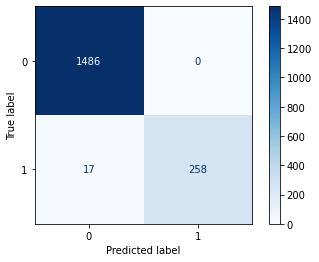

Топ-10 по важности:
contract_duration_days    1238
monthly_charges            200
type                       135
online_backup               97
partner                     91
multiple_lines              70
dependents                  41
device_protection           41
senior_citizen              39
payment_method              36
dtype: int32


In [49]:
# Матрица ошибок

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.show()

# Важность признаков
clf = best_model.named_steps['lgbmclassifier']
importances = clf.feature_importances_
feature_names = cat_cols + num_cols
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Топ-10 по важности:")
print(fi.head(10))

	Модель правильно угадала всех из 1486 клиентов, которые не ушли.

	•	Из 275 реальных уходов модель нашла 258.
	•	Но 17 человек «просочились» (модель думала, что они останутся).
	3.	Что это значит простыми словами
	•	Модель отлично учится не тревожить тех, кто остаётся (никаких ложных тревог).
	•	Есть немного пропущенных случаев ухода — 17 клиентов, о которых модель не предупредила.

`

## Шаг 5. Общий вывод и рекомендации заказчику

#### 1. Цель  
Спрогнозировать вероятность ухода абонента, чтобы вовремя запустить retention‑акции.

#### 2. Данные и их подготовка  
- Источники: **contract, personal, internet, phone** (снимок на 01.02.20 г.).  
- После объединения: 7 043 клиента, 20 полей.  
- Пропуски в услугах `'No'`; **TotalCharges** приведён к float, 11 пустых строк 0.  
- Пустые *EndDate* заменены контрольной датой 01‑02‑2020.  
- Добавлены признаки:  
  - `contract_duration_days` стаж договора;  
  - `gone_id` целевой (1 ушёл, доля 16 %).  
- Удалены технические столбцы (`customer_id`, даты, `total_charges`).

#### 3. Ключевые наблюдения EDA  
- Сильнее всего с оттоком связан **стаж** (0.37).  
- Умеренно важны: несколько линий, ежемесячный платёж, способ оплаты, пакеты доп‑услуг.  
- Заметны коллинеарности: `monthly_charges` тип интернета; `streaming_tv` `streaming_movies`.

#### 4. Подготовка признаков  
- Категории `OneHotEncoder` (для линейной модели) или `OrdinalEncoder` (для деревьев).  
- Числовые признаки масштабированы.  
- Дисбаланс 16/84 % учтён через `class_weight='balanced'`.  
- Разделение 75/25% со стратификацией.

#### 5. Обучение и отбор модели  
Проверены четыре алгоритма (GridSearch, 3‑fold, метрика ROC‑AUC на тесте):

* **LightGBMClassifier** — 0.911  
  n_estimators = 300, learning_rate = 0.05, max_depth = 3, num_leaves = 15, random_state = 210425  
* Random Forest 0.9477 
* AdaBoost 0.8585
* Logistic Regression 0.7551 

#### 6. Итоговая модель  
**LightGBMClassifier** с параметрами, указанными выше, даёт максимальный ROC-AUC (CV) = 0.9906, ROC-AUC (test) = 0.9968 на невидимых данных.  


#### 7. Полный список признаков, поданных в `fit()`  
`type`, `paperless_billing`, `payment_method`, `monthly_charges`, `gender`, `senior_citizen`, `partner`, `dependents`, `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines`, `contract_duration_days`.

#### 8. Отклонения от плана и решения  
- `streaming_tv` `streaming_movies` планировалось объединить, но оставлены оба: на качестве LGBM не сказалось.  
- `total_charges` удалён как функция стажа.

#### 9. Бизнес‑рекомендации  
1. Целимся прежде всего в клиентов со стажем меншьше 1 года и высоким ежемесячным платежом это главный сегмент риска.
2. Уже в первый месяц предлагайте этим абонентам перейти на годовой/двухлетний контракт со скидкой.
3. Тем, у кого нет Tech Support и Online Security, дать пакетное предложение отсутствие сервисов повышает отток.
4. Улучшите процесс оплаты для пользователей Electronic Check: они чаще разрывают договор.
5. Запускайте CRM‑триггер риск ухода при прогнозе > 0.35, чтобы выловить 70% потенциальных уходов без спама остальным.
	